# Fitting a scaled LDA model via proximal gradient descent
_Date:_ October 7, 2024

This notebook features the same model and algorithm as in `2024-10-03-Scaled-LDA-EM-PGD.ipynb`.
The previous notebook worked with a $K=3$ topic, $V=5$ word model, with $\alpha_0^{(\theta)} = 1$ prior concentration.
While we demonstrated that the proposed EM-PGD model was able to recover the true parameters,
it was largely only able to do so when it a model with $\tilde{K} > K$.
It is typical practice in topic models to fit models with more topics than the true generating distribution,
then perform post-hoc "pruning" of redundant topics or topics that explain a small amount of the variance.

We were not able to clearly identify a robust strategy for estimate the true number of topics $\hat{K}$ from the fitted number of topics $\tilde{K}$.
This may be due to the very small size. In this notebook, we generate data from a model with more topics and larger vocabulary.
The goal is to identify a robust strategy for estimating the true number of topics.

We implemented some changes that led to massive speed-ups, including
- projecting onto the simplex via sorting, instead of bisection search (see `project_simplex_2` function)
- scanning through the E-M steps instead of for looping
- vector mapping over different initializations or folds.
In sum, we are now able to run 200 iterations of EM, over 5 different initializations, in 1-3 minutes. Previously, this took >>30 minutes.

These changes were essential in quickly performing cross-validation to find the most parsimonious number of topics for the given data.
For the $K=6$, $V=30$ data generating model, we chose a $\tilde{K}=8$ model based on the held-out log likelihood through this procedure.
We fit 5 different intializations of a $\tilde{K}=8$ model, but found that in most cases, the topics did not deviate significantly from their initialization.
Parameter updates were dominated by changes in the weights (qualitiatively, looked like the model was pushing the weights toward uniform.)

We make the following observations:
1. Standard model selection best practices advise choosing the model parameters at the "shoulder" (inverse "elbow") of held-out log likelihood curve. This balances model expressivity vs. complexity. However, LDA modeling best practices suggest that one should "overfit" the number of topics, then post-hoc prune the topics (reference needed). So, perhaps we should treat the "shoulder" as the _minimum_ number of topics that we should be fitting.
    - Alternatively, fitting to many more topics may simply be a symptom of poor initializations. By fitting to many more topics, you have a better chance of some initializations near the true topics.
    - _Aside:_ I'm curious if the singular Bayesian Information Criterion (sBIC) for LDA models proposed by [Bystrov et al. (2024)](https://www.jmlr.org/papers/volume25/23-0188/23-0188.pdf) accurately captures this "shoulder".
2. Needing to fit to $\tilde{K}>>K$ may additionally or alternatively be a hot fix for bad intializations. I observed that when sampling from a Dirichlet distribution (even with low concentration), samples were not always "seperable" or distinct from each other. We should be generating data from topics that are clearly distinct from each other (as commented by Bystrov et al. (2024), )
3. The parameter updates were dominated by changes in the weights.
    - What happens if we just initialized the weights uniformly to `1/K`? We liked the random sampling for the topics to break any symmetries, but maybe it'd be helpful to have the symmetry for the weights.
    - The `sklearn` implementation has a parameter `max_doc_topic_iters` which specifies the maximum number of document-topic (weights) update iterations per E-step. I believe this parameter is only relevant to their algorithm (based off of Hoffman et al.'s SVI paper), but I would need to look more clearly to understand it.
4. Training did not techinically occur, even after 200 iterations.
    - I should train to full convergence; maybe something magical happens.
    - Is there anyway to speed-up convergence? EM with momentum? This idea was explored for HMMs in [Miller et al. (2022)](https://arxiv.org/abs/2206.04057), who use the difference between parameters before and after an update as a "discrete gradient" and apply a momentum hyperparameter.
5. Is it possible that the model is not identifiable, especially in the regime $\alpha_\sigma \rightarrow 0$? One thing we don't consider is that vocabulary usage across all of the topics is not uniform.

**Next steps**
1. Generate data from topics that are well-seperated. Follow the cosine distance metric used by Bystrov et al. 2024 to evaluate a collection of topics and generate topics.
2. Re-examine the $\alpha_\sigma \rightarrow \infty$, aka standard LDA case. Sanity check that we did not break our algorithm in some way, and revisit some "best practices" for recovery the true topics.
3. If sanity check for standard LDA passes, evaluate model performance as a function of $\alpha_\sigma$ value, for a given topic and weights set.
4. Try initializing weights with uniform $1/K$. Does this help or hurt model optimization?

In [7]:
from collections import namedtuple
from typing import Optional, Sequence
from jax.typing import ArrayLike
from jax import Array
KeyArray = Array

from functools import partial
import pickle
from tqdm.auto import tqdm

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr

import numpy as onp

from scipy.spatial.distance import cdist, pdist
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
auto_integer_tick_locator = mpl.ticker.MaxNLocator(nbins='auto', steps=[1,2,5,10], integer=True)

## Proximal gradient descent

### Generic PGD with backtracking line search

In [8]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given
    proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, n_backtrack_steps = lax.while_loop(
            _backtrack_cond, _backtrack_body, (max_stepsize, 0)
        )

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, n_steps = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

In [9]:
@jit
def _simplex_lagrangian(w, lmbda):
    return jnp.sum(jnp.clip(w - lmbda, a_min=0.0)) - 1.0


def bisect_jax(f, a, b, tol=1e-8, max_iter=1000):
    """Find a root of f via bisection.

    Args:
        f: a function that is monotonically increasing or decreasing on the interval [a, b]
        a: lower bound on root
        b: upper bound on root
    """
    def _bisect_cond(state):
        (a, f_a), (b, f_b), counter = state
        # m = (a + b) / 2
        return (abs(f(a)) > tol) & ((b - a) / 2 > tol) & (counter < max_iter)

    def _bisect_body(state):
        (a, f_a), (b, f_b), counter = state
        m = (a + b) / 2
        f_m = f(m)
        # if sign(f(m)) = sign(f(m)) then a <- m else b <- m // new interval
        state = lax.cond(jnp.sign(f_m) == jnp.sign(f_a),
                        lambda: ((m, f_m), (b, f_b), counter+1), # predicate true
                        lambda: ((a, f_a), (m, f_m), counter+1), # predicate false
                        )
        return state

    init_state = ((a, f(a)), (b, f(b)), 0)
    ((a, fa), (b, fb), counter) = lax.while_loop(_bisect_cond, _bisect_body, init_state)
    # print("num iters: ", counter)
    return a


def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the approach in Ch 6.2.5 of
    https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    """
    lmbda_max = jnp.max(w)
    lmbda_star = bisect_jax(partial(_simplex_lagrangian, w),
                            lmbda_max - 1, lmbda_max)
    return jnp.clip(w - lmbda_star, a_min=0.0)

In [10]:
# Test it on some inputs
with jnp.printoptions(precision=2):
    for name, u in [
        ("noneg vec", jnp.array([0.2, 0.9, 1.4])),
        ("real vec", jnp.array([-0.4, 0.9, 0.2])),
        ("unit simplex", jnp.array([0.33, 0.33, 0.33])),
        ("a-simplex", jnp.array([3.3, 3.3, 3.3])),
    ]:
        v = project_simplex(u, 0)
        print(f"{name}:\t Proj({u})\t-> {v}")
        assert jnp.all(v >= 0) & jnp.isclose(v.sum(), 1.0)

2024-10-09 11:26:46.339416: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


noneg vec:	 Proj([0.2 0.9 1.4])	-> [0.   0.25 0.75]
real vec:	 Proj([-0.4  0.9  0.2])	-> [0.   0.85 0.15]
unit simplex:	 Proj([0.33 0.33 0.33])	-> [0.33 0.33 0.33]
a-simplex:	 Proj([3.3 3.3 3.3])	-> [0.33 0.33 0.33]


In [11]:
def project_simplex_2(w, dummy_stepsize):
    """Project onto simplex following the algorithm described in
    Duchi et al. (2008), https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf,
    and following the implementation provided in Wang and Carreira-Perpinan (2013),
    https://home.ttic.edu/~wwang5/papers/SimplexProj.pdf

    Params:
        w: shape [..., D]
    """

    dim = w.shape[-1]

    # sort input vector from highest to lowest elements
    w_sorted = jnp.sort(w, axis=-1, descending=True)

    # enumerate all possible breakpoints
    mus = jnp.cumsum(w_sorted, axis=-1) - 1
    mus /= jnp.arange(dim, dtype=float) + 1

    # find index of last breakpoint for which w_sorted - mu > 0
    j = sum(w_sorted > mus) - 1

    return jnp.maximum(0, w-mus[...,j])

with jnp.printoptions(precision=2):
    for name, w in [
        ("noneg vec", jnp.array([0.2, 0.9, 1.4])),
        ("real vec", jnp.array([-0.4, 0.9, 0.2])),
        ("unit simplex", jnp.array([0.33, 0.33, 0.33])),
        ("a-simplex", jnp.array([3.3, 3.3, 3.3])),
    ]:
        v = project_simplex_2(w, 0)
        print(f"{name}:\t Proj({w})\t-> {v}")
        assert jnp.all(v >= 0) & jnp.isclose(v.sum(), 1.0)

noneg vec:	 Proj([0.2 0.9 1.4])	-> [0.   0.25 0.75]
real vec:	 Proj([-0.4  0.9  0.2])	-> [0.   0.85 0.15]
unit simplex:	 Proj([0.33 0.33 0.33])	-> [0.33 0.33 0.33]
a-simplex:	 Proj([3.3 3.3 3.3])	-> [0.33 0.33 0.33]


In [ ]:
%timeit project_simplex(w,0)

79.6 ms ± 684 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit project_simplex_2(w,0)

1.13 ms ± 20.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Wow, that's an 45x reduction in the projection step! The projection step is called with every backtracking step, in the PGD loop, so this is going to be a pretty significant reduction.

## Scaled LDA Model

### Generate data

In [12]:
Params = namedtuple("Params", [
    "topics", "weights", "scales", "scounts"
    ], defaults=(None, None)
)

PriorParams = namedtuple("PriorParams", [
    "topic_conc", "weight_conc", "scale_conc", "scount_conc",
    "topic_rate", "weight_rate", "scale_rate", "scount_rate",
    ], defaults=(1.00, 1.00, 1.00, 1.00, 1e-4, 1e-4, 1e-4, 1e-4)
)

In [9]:
def sample_params_and_data(seed: KeyArray,
                           n_topics: int,
                           vocab_size: int,
                           n_docs: int,
                           doc_length_rate: float,
                           topic_conc: float=1.001,
                           weight_conc: float=1.001,
                           scale_conc: float=1.001) -> tuple[Params, Array]:
    """Sample parameters and generate data."""
        
    s1, s2, s3, s4, s5 = jr.split(seed, 5)

    # Sample topics, shape (n_topics, vocab_size)
    alpha_ = jnp.broadcast_to(jnp.asarray(topic_conc, dtype=float), (vocab_size,),)
    topics = jr.dirichlet(s1, alpha_, shape=(n_topics,))

    # Sample doc-topic weights, shape (n_docs, n_topics)
    alpha_ = jnp.broadcast_to(jnp.asarray(weight_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(s2, alpha_, shape=(n_docs,))
    
    # Sample word scales, shape (vocab_size,)
    alpha_ = jnp.broadcast_to(jnp.asarray(scale_conc, dtype=float), (vocab_size,))
    scales = jr.dirichlet(s3, alpha_, shape=())

    # Sample document lengths, shape (n_docs,). Although lengths are integer-valued,
    # we convert to float dtype becaused this is the dtype expected by tfd.Multinomial.
    lengths = jr.poisson(s4, doc_length_rate, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)
    
    # Sample data, shape (n_docs, vocab_size)
    rates = (scales * (weights @ topics))
    probs = rates / rates.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), s5)

    # Calculate scounts so that we can compare parameters with it later
    scounts = lengths / rates.sum(axis=-1)

    params = Params(topics, weights, scales, scounts)

    return params, data

# ========================================================================================

n_topics = 50  # target = 6 topics
vocab_size = 30
topic_conc = 0.01  # Choosing <1 for sparser topics

n_docs = 5000
doc_length_rate = 1000  # expected document length

seed = jr.key(42)
true_params, data = sample_params_and_data(
    seed, n_topics, vocab_size, n_docs, doc_length_rate=doc_length_rate
)

Text(0.5, 1.15, 'Scaled LDA')

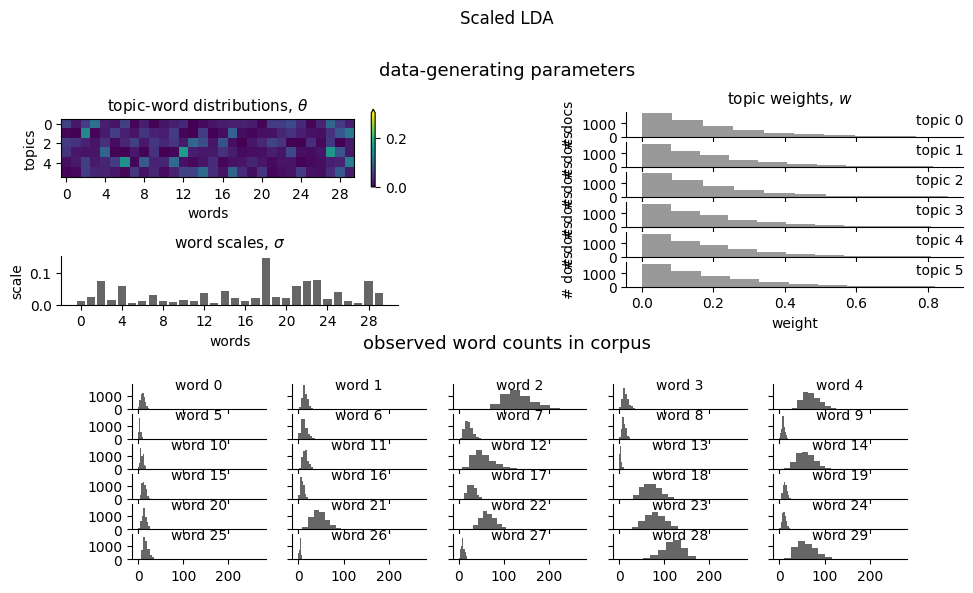

In [130]:
def plot_model_param_and_data(
    params: dict,
    data: Array,
    topic_vmax: float=1.,
    max_n_vocab_ticks: int=10,
    max_n_topic_ticks: int=5,
):
    
    topics, weights, scales = params.topics, params.weights, params.scales
    n_topics, vocab_size = topics.shape

    subfig_title_size = 13
    subfig_title_y = 1.1
    subplot_title_size = 11

    vocab_ticker = mpl.ticker.MaxNLocator(max_n_vocab_ticks, integer=True)
    topic_ticker = mpl.ticker.MaxNLocator(max_n_topic_ticks, integer=True)

    fig = plt.figure(figsize=(10,5))
    subfigs = fig.subfigures(2, 1, height_ratios=[1,1], hspace=0.2)

    # ===========================
    # Subfig 1: Model params
    # ===========================
    subfigs[0].suptitle('data-generating parameters', y=subfig_title_y, fontsize=subfig_title_size)
    param_subfigs = subfigs[0].subfigures(1, 2, wspace=0.3)

    # ---------------------------
    # Topics and word scales
    # ---------------------------
    subfig = param_subfigs[0].subfigures(2, height_ratios=[2,1], hspace=0.4)
    
    # Topics
    ax = subfig[0].subplots()

    im = ax.imshow(topics, vmin=0, vmax=topic_vmax)
    plt.colorbar(
        im, ax=ax, location='right', pad=0.05, fraction=0.08, shrink=0.8,
        extend='max' if topic_vmax < 1 else 'neither',
    )

    ax.set_xlabel('words'); ax.xaxis.set_major_locator(vocab_ticker)
    ax.set_ylabel('topics'); ax.yaxis.set_major_locator(topic_ticker)
    ax.set_title(r'topic-word distributions, $\theta$', fontsize=subplot_title_size)

    # Scales
    ax = subfig[1].subplots()

    ax.bar(range(vocab_size), scales, fc='0.4')
    ax.set_xlabel('words'); ax.xaxis.set_major_locator(vocab_ticker)
    ax.set_ylabel("scale");
    sns.despine(ax=ax)
    ax.set_title(r'word scales, $\sigma$', fontsize=subplot_title_size)

    # ---------------------------
    # Weights
    # ---------------------------
    axs = param_subfigs[1].subplots(n_topics, sharex='all', sharey='all')
    for k, ax in enumerate(axs):
        ax.hist(weights[:,k], fc='0.6')
        ax.text(1, 0.95, f"topic {k}", transform=ax.transAxes, ha='right', va='top')
        ax.set_ylabel('# docs')
        sns.despine(ax=ax)
        
    axs[-1].set_xlabel('weight')
    param_subfigs[1].suptitle(r'topic weights, $w$', fontsize=subplot_title_size)

    # ===========================
    # Row 2: Word usage counts
    # ===========================
    ncols = 5
    nrows = vocab_size // ncols + (vocab_size % ncols)

    subfigs[1].suptitle('observed word counts in corpus', y=subfig_title_y, fontsize=subfig_title_size)
    axs = subfigs[1].subplots(nrows, ncols, sharex='all', sharey='all')

    for v, ax in enumerate(axs.ravel()):
        ax.hist(data[:,v], fc='0.4')
        ax.text(0.5, 0.95, f"word {v}", transform=ax.transAxes, ha='center', va='center')
        sns.despine(ax=ax)
    # axs[0].set_ylabel('# counts')

    return fig

# ----------------------------------------------------------------------------------------
fig = plot_model_param_and_data(true_params, data, topic_vmax=0.30)
fig.suptitle(f'Scaled LDA', y=1.15)

**Figure.** Model parameters and observed word counts of scaled LDA model.
The `word_scale_conc` concentrations are explicitly set to be adversarial:
We see that topic 1 has large mass on word 1, but word 1 makes up a significantly less fraction of observed words
than, for example, words 2, 3, and 4.

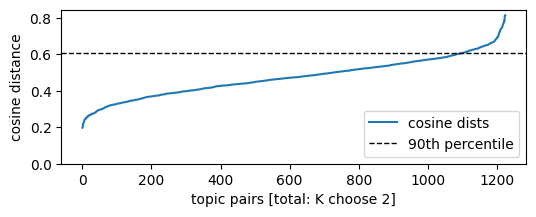

In [47]:
cosine_dists = pdist(true_params.topics, 'cosine')  # (K**2 - K) / 2 elements
i_sort = onp.argsort(cosine_dists)
sorted_cosine_dists = cosine_dists[i_sort]

plt.figure(figsize=(6,2))
plt.plot(sorted_cosine_dists, label='cosine dists')
plt.ylabel('cosine distance')
plt.xlabel('topic pairs [total: K choose 2]')
plt.ylim(bottom=0)

pct = 90
threshold = onp.percentile(sorted_cosine_dists, pct)
plt.axhline(threshold, color='k', ls='--', lw=1, label=f"{pct}th percentile")
plt.legend()

In [23]:
K_sim = 50  # number of topics we simulated
K_target = 6  # number of topics we actually want

ijs = onp.stack(onp.triu_indices(K_sim, 1), axis=-1) # shape (K_sim_choose_2, 2)
ijs = ijs[i_sort].ravel() # indices, sorted by cosine distance. length (K_sim_choose_2 * 2,)
ijs = ijs[::-1]  # now, make sure that they are sorted by further apart

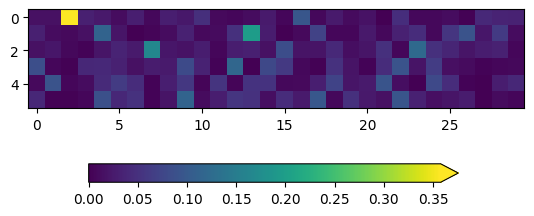

In [24]:
# Choose the first K_target topics only chooses the first K_target/2 topics that are PAIRWISE dissimilar
# maybe not globally dissimilar
_, idx = onp.unique(ijs, return_index=True)
ijs_target = ijs[onp.sort(idx)[:K_target]]

plt.imshow(true_params.topics[ijs_target], vmin=0)
plt.colorbar(location='bottom', extend='max', fraction=0.05)

# these pairwise distances, but maybe not global

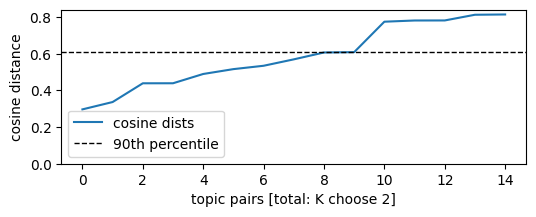

In [25]:
subtopics = true_params.topics[ijs_target]
sub_cosine_dists = pdist(subtopics, 'cosine')

i_sort = onp.argsort(sub_cosine_dists)
sorted_sub_cosine_dists = sub_cosine_dists[i_sort]

plt.figure(figsize=(6,2))
plt.plot(sorted_sub_cosine_dists, label='cosine dists')
plt.ylabel('cosine distance')
plt.xlabel('topic pairs [total: K choose 2]')
plt.ylim(bottom=0)

# use threshold from before
plt.axhline(threshold, color='k', ls='--', lw=1, label=f"{pct}th percentile")
plt.legend()

# indeed, we see that we should do this iteratively

In [57]:
_, ij_unique = onp.unique(ijs, return_index=True)
sorted_ijs = ijs[onp.sort(ij_unique)]

selected_topics = true_params.topics[sorted_ijs[:2]]

threshold = 0.5
for i, idx in enumerate(sorted_ijs[2:]):
    candidate_topics = onp.concatenate(
        [selected_topics, true_params.topics[onp.atleast_1d(idx)]]
    )
    if all(pdist(candidate_topics, 'cosine') >= threshold):
        selected_topics = candidate_topics

    if (len(selected_topics) > K_target):
        break

print(len(selected_topics))

6


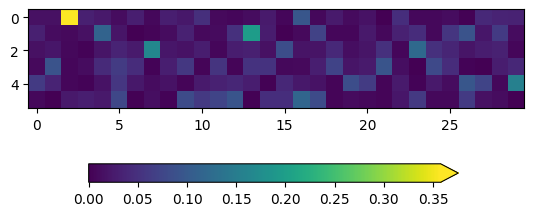

In [59]:
plt.imshow(selected_topics, vmin=0)
plt.colorbar(location='bottom', extend='max', fraction=0.05)


In [45]:
idx = sorted_ijs[3]
candidate_topic = true_params.topics[idx]


tmp.shape


    print('hllo')

hllo


### Infer parameters with variational Bayes

In [17]:
# Infer with variational Bayes (VB)

lda = LDA(n_topics,)

lda.fit(data)

topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
weights = lda.transform(data)

vb_params = Params(topics, weights)

# ----------------------------------------------------------------------
# Permute VB topics to best match data-generating topics.
# metric='jensonshannon': Use Jensen-Shannon divergence (smoothed and symmetrized version of KL div,
# bounded between 0 and 1). Good enough for our purposes

# negative cross-entropy
nxent = lambda p, q: (p * jnp.log(jnp.clip(q, a_min=1e-4))).sum()

cost_matrix = cdist(true_params.topics, vb_params.topics, metric=nxent)
_, i_permute = linear_sum_assignment(cost_matrix)

vb_params = Params(vb_params.topics[i_permute], vb_params.weights[:,i_permute],)

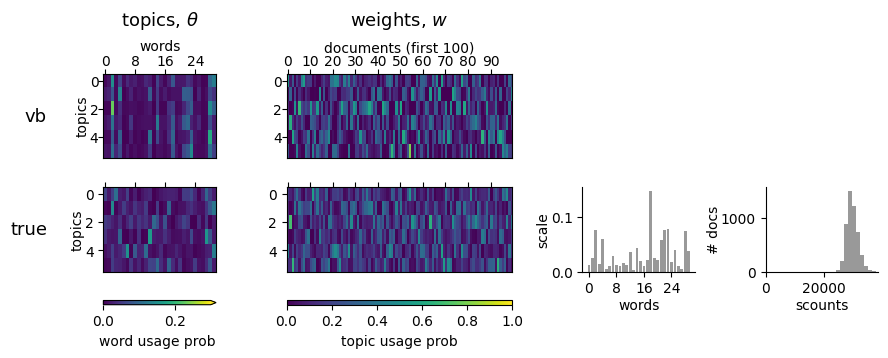

In [69]:
def compare_params(
    dict_of_params, fig=None,
    topic_vmax: float=1.0,
    weight_vmax: float=1.0,
    max_n_vocab_ticks: int=10,
    max_n_topic_ticks: int=5,
    max_n_docs: int=100,
):
    tickpad = 0.05
    vocab_ticker = mpl.ticker.MaxNLocator(max_n_vocab_ticks, integer=True)
    topic_ticker = mpl.ticker.MaxNLocator(max_n_topic_ticks, integer=True)

    for params in dict_of_params.values():
        n_docs = len(params.weights)
        break
    
    n_param_sets = len(dict_of_params)

    fig, all_axs = plt.subplots(
        nrows=n_param_sets+1, height_ratios=(1,)*n_param_sets + (0.05,),
        ncols=4, width_ratios=(1,2,1,1),
        gridspec_kw={"hspace": 0.5, "wspace": 0.5},
        figsize=(10,len(dict_of_params)+1)
    )

    # ======================================================
    # Topics (heatmap)
    # ======================================================
    i_col = 0
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]

    for ax, params in zip(axs, dict_of_params.values()):
        n_topics, vocab_size = params.topics.shape
        im = ax.imshow(params.topics, vmin=0, vmax=topic_vmax, aspect="auto", interpolation="none")
        
        # x-axis: vocab
        ax.xaxis.set_major_locator(vocab_ticker)
        ax.tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)

        # y-axis: topics
        ax.set_ylabel("topics", labelpad=0)
        ax.yaxis.set_major_locator(topic_ticker)

    # Label x-axis of top row
    axs[0].set_xlabel(f"words", labelpad=3)
    axs[0].xaxis.set_label_position('top')
    axs[0].tick_params(top=True, labeltop=True, pad=tickpad)

    # Show colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='word usage prob',
                 extend="max" if topic_vmax < 1 else "neither")

    # ======================================================
    # Weights (heatmap)
    # ======================================================
    i_col = 1
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]

    n = 100
    for ax, params in zip(axs, dict_of_params.values()):
        n_docs, n_topics = params.weights.shape
        im = ax.imshow(params.weights[:n].T, vmin=0, vmax=weight_vmax, aspect="auto", interpolation="none")
        
        # x-axis: docs
        ax.set_xticks(jnp.linspace(0, n, num=min(10, n), endpoint=False));
        ax.tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)

        # y-axis: topics
        # ax.set_ylabel("topics", labelpad=0);  # use the ylabels from topics
        ax.yaxis.set_major_locator(topic_ticker)

    # Label x-axis of top row
    axs[0].set_xlabel(f"documents (first {n})", labelpad=2, )
    axs[0].xaxis.set_label_position('top')
    axs[0].tick_params(top=True, labeltop=True, bottom=False, pad=tickpad)

    # colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='topic usage prob',
                 extend="max" if weight_vmax < 1 else "neither")

    # ======================================================
    # Scales (bar plot)
    # ======================================================
    i_col = 2
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    ymax = 0
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scales is None:
            ax.remove()
        else:
            ax.bar(range(vocab_size), params.scales, fc='0.6')
            
            # x-axis: vocab
            ax.xaxis.set_major_locator(vocab_ticker)
            ax.tick_params(labelbottom=False)  # only show ticks for last row

            # y-axis: scales
            ax.set_ylabel("scale", labelpad=0)
    
            ymax = max(ymax, ax.get_ylim()[1])

            sns.despine(ax=ax)
    
    # manually share y-axis
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scales is not None:
            ax.set_ylim(top=ymax)

    ax.set_xlabel(f"words", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Scounts (histogram)
    # ======================================================
    i_col = 3
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    xmax, ymax = 0, 0
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scounts is not None:
            ax.hist(params.scounts, fc='0.6')
            ax.tick_params(labelbottom=False)
            ax.set_xlim(left=0)
            sns.despine(ax=ax)
            ax.set_ylabel("# docs", labelpad=0.)
            
            ymax = max(ymax, ax.get_ylim()[1])
            xmax = max(xmax, ax.get_xlim()[1])
        
        else: 
            ax.remove()
    
    # manually share x-axis and y-axis
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scounts is not None:
            ax.set_ylim(top=ymax)
            ax.set_xlim(right=xmax)

    ax.set_xlabel(f"scounts", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Super-labels
    # ======================================================
    # Rows: Parameter set name
    for ax, name in zip(all_axs[:-1,0], dict_of_params.keys()):
        ax.text(-0.5, 0.5, name, ha='right', va='center', fontsize=13, transform=ax.transAxes)

    # Columns: Parameter names
    for ax, name in zip(all_axs[0], [r"topics, $\theta$", r"weights, $w$", r"scales, $\sigma$", r"scounts, $c$"]):
        ax.text(0.5, 1.5, name, ha='center', va='bottom', fontsize=13, transform=ax.transAxes)

    return fig

fig = compare_params(
    {"vb": vb_params, "true": true_params,},
    topic_vmax=0.3,
    max_n_vocab_ticks=5,
    max_n_topic_ticks=3,
    max_n_docs=50,
)

**Figure** Inference under the standard LDA model using variational Bayes does not recover the data-generating topics.
Instead, it places (relatively) too much mass on words 3 and 4, which make up a significant portion of observed word counts.

### Infer parameters with EM and PGD

We compute the E-step as usual. For the M-step, we use the PGD algorithm. This should exactly calculate the maximizing values because the parameters should already lie in the simplex.

**E-step**

In [19]:
def e_step(data, topics, weights, scales):
    """Compute posterior expected sufficient statistics of parameters.

    Parameters
        X: data tensor, shape (M,V)
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (V,)

    Returns
        expected_zs: expected counts allocation, shape (M, K, V)
    """
    rhos = scales * jnp.einsum('mk, kv -> mkv', weights, topics)
    rhos /= jnp.clip(rhos.sum(axis=1, keepdims=True), a_min=1e-4)
    expected_zs = data[:,None,:] * rhos  # shape (M,K,V)
    return expected_zs

# ------------------------------------------------
# sanity check: make sure it runs without error
expected_zs = e_step(data, true_params.topics, true_params.weights, true_params.scales)

**M-step**

In [20]:
def gamma_dirichlet_pgd(x0, alpha, beta, amin=1e-4, max_stepsize=1e0, max_num_steps=100):
    
    # Standardize params to be order 1
    c = jnp.maximum(alpha.max(), beta.max())
    alpha = 1. + (alpha-1) / c
    beta = beta / c

    gamma_objective = lambda x: \
        -1.0 * tfd.Gamma(alpha, rate=beta).log_prob(jnp.clip(x, min=amin)).mean()

    return prox_grad_descent(
        gamma_objective, project_simplex_2, x0,
        max_stepsize=max_stepsize, max_num_steps=max_num_steps
    )

# vmap over initial params, alpha, and beta
v_gamma_dirichlet_pgd = vmap(gamma_dirichlet_pgd, in_axes=(0,0,0,None,None))

In [21]:
def m_step_topics(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=0) + prior_conc
    rate = jnp.einsum('m,v,mk->kv', scounts, scales, weights) + prior_rate
    
    new_topics = v_gamma_dirichlet_pgd(topics, conc, rate, a_min, max_stepsize)
    return new_topics

def m_step_weights(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=-1) + prior_conc
    rate = jnp.einsum('m,v,kv->mk', scounts, scales, topics) + prior_rate

    new_weights = v_gamma_dirichlet_pgd(weights, conc, rate, a_min, max_stepsize)

    return new_weights

def m_step_scales(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(0,1)) + prior_conc
    rate = jnp.einsum('m,mk,kv->v', scounts, weights, topics) + prior_rate

    new_scales = gamma_dirichlet_pgd(scales, conc, rate, a_min, max_stepsize)

    return new_scales

def m_step_scounts(expected_zs, topics, weights, scales, scounts, prior_params):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(1,2)) + prior_conc
    rate = jnp.einsum('v,mk,kv->m', scales, weights, topics) + prior_rate
    
    new_scounts = (conc-1) / rate

    return new_scounts

**Putting it together**

In [22]:
def multinomial_ll(data, topics, weights, scales, scounts=None):
    """Compute multinomial LL of data given model params."""

    probs = scales * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)

    return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data)

def em(
    init_topics,
    init_weights,
    init_scales,
    init_scounts,
    data: Array,
    prior_params: PriorParams,
    max_em_steps: int=10,
    max_stepsize: dict | float=1e0,
    update_topics: bool=True,
    update_weights: bool=True,
    update_scales: bool=True,
):
    """
    Params
        data: shape (M, D)
        mask: shape (M,)
            Boolean array. If True, use data in training. Else, use data for 
    """

    # Standardize max_stepsize to be dict
    if isinstance(max_stepsize, (int, float)):
        max_stepsize = {param_: max_stepsize for param_ in ('topics', 'weights', 'scales')}
    assert isinstance(max_stepsize, dict)
    
    def step(carry, i):
        topics, weights, scales, scounts = carry

        if update_topics:
            expected_zs = e_step(data, topics, weights, scales)

            topics = m_step_topics(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_params.topic_conc, prior_params.topic_rate),
                max_stepsize=max_stepsize['topics']
            )
        
        if update_weights:
            expected_zs = e_step(data, topics, weights, scales)

            weights = m_step_weights(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_params.weight_conc, prior_params.weight_rate),
                max_stepsize=max_stepsize['weights']
            )
        
        if update_scales:
            expected_zs = e_step(data, topics, weights, scales)

            scales = m_step_scales(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_params.scale_conc, prior_params.scale_rate),
                max_stepsize=max_stepsize['scales']
            )

        # Always update scounts
        expected_zs = e_step(data, topics, weights, scales)

        scounts = m_step_scounts(
            expected_zs,
            topics, weights, scales, scounts,
            (prior_params.scount_conc, prior_params.scount_rate),
        )

        ll = multinomial_ll(data, topics, weights, scales).mean()

        return (topics, weights, scales, scounts), (ll, topics, weights, scales, scounts)
    
    _, (all_lls, all_topics, all_weights, all_scales, all_scounts) \
        = jax.lax.scan(step, (init_topics, init_weights, init_scales, init_scounts), length=max_em_steps)

    return all_lls, all_topics, all_weights, all_scales, all_scounts

In [25]:
def initialize_params(key, data, n_topics, topics_conc=1.00, weights_conc=1.00):
    n_docs, vocab_size = data.shape
    
    topics_seed, weights_seed = jr.split(key)

    topics = jr.dirichlet(topics_seed, topics_conc*jnp.ones(vocab_size), (n_topics,))
    weights = jr.dirichlet(weights_seed, weights_conc*jnp.ones(n_topics), (n_docs,))

    scales = jnp.median(data, axis=0)
    scales /= scales.sum(keepdims=True)
    
    scounts = data.sum(axis=-1) * vocab_size

    return topics, weights, scales, scounts

### Cross-validate to identify number of topics $\tilde{K}$

Not the most proper cross validation. Doing 1 mask for 5 different inits.

In [58]:
def cross_validate(key, n_topics, n_folds, data, prior_params, n_train_steps, n_vldtn_steps, max_stepsize=1e0):
    """K-folds cross-validation.

    Parameters
        key:
        n_folds: int
        data: shape (n_docs, vocab_size)
        topics: shape (n_topics, vocab_size)
        ...
        prior_params

    """

    cv_key, init_key = jr.split(key)

    n_docs, vocab_size = data.shape

    # Generate holdout masks, shape (n_folds, n_docs//n_folds,)
    holdout_idxs = jnp.array_split(jr.permutation(cv_key, n_docs), n_folds)
    holdout_idxs = jnp.array([idxs[:n_docs//n_folds] for idxs in holdout_idxs])

    # Don't use masking; this would require fitting weights for all of the data,
    # then just computing ll off of a very small subset. Instead, split train
    # and vldtn datas by rolling through holdout idxs

    fit = partial(em, prior_params=prior_params, max_em_steps=n_train_steps, max_stepsize=max_stepsize,)
    partial_fit = partial(em, prior_params=prior_params, max_em_steps=n_vldtn_steps, max_stepsize=max_stepsize, update_topics=False, update_scales=False)

    def cv_fold(i_fold):
        train_key, vldtn_key = jr.split(jr.fold_in(init_key, i_fold))

        idxs = jnp.roll(holdout_idxs, i_fold, axis=0)
        vldtn_data = jnp.take(data, idxs[0], axis=0, unique_indices=True)
        train_data = jnp.take(data, idxs[1:].ravel(), axis=0, unique_indices=True)

        init_topics, init_weights, init_scales, init_scounts\
            = initialize_params(train_key, train_data, n_topics)
        
        all_lls, all_topics, _, all_scales, _ = fit(
            init_topics, init_weights, init_scales, init_scounts, train_data,
        )

        fitted_topics, fitted_scales = all_topics[-1], all_scales[-1]

        # Draw a new set of validation weights
        _, init_vldtn_weights, _, _ = initialize_params(vldtn_key, vldtn_data, n_topics)

        # Manually perform an M-step to get scounts
        init_vldtn_scounts = vldtn_data.sum(axis=-1)  # equivalent to expected_zs.sum(axis=(1,2))
        init_vldtn_scounts /= jnp.einsum('v,mk,kv->m', fitted_scales, init_vldtn_weights, fitted_topics)

        # initialize with  original weights
        vldtn_lls, *_ = partial_fit(
            fitted_topics, init_vldtn_weights, fitted_scales, init_vldtn_scounts, vldtn_data,
        )

        return all_lls, vldtn_lls

    train_lls, vldtn_lls = vmap(cv_fold)(jnp.arange(n_folds))

    return train_lls, vldtn_lls

In [90]:
n_folds = 3
n_inits = 5
n_train_steps = 100
n_vldtn_steps = 50
max_stepsize = 1e0

n_topics_sweep = jnp.array([2, 4, 6, 8, 10, 12, 20])  # 9m 22s

keys = jr.split(jr.key(49328), n_inits)

# (n_inits, n_folds, n_steps)
all_train_lls, all_vldtn_lls = [], []
for n_topics in n_topics_sweep:
    train_lls, vldtn_lls = vmap(
        lambda key: cross_validate(
                key, n_topics, n_folds, data, prior_params, n_train_steps, n_vldtn_steps, max_stepsize
        ),
    )(keys)

    all_train_lls.append(train_lls.reshape(-1, n_train_steps))
    all_vldtn_lls.append(vldtn_lls.reshape(-1, n_vldtn_steps))

# shape (n_topics_sweep, n_folds * n_inits, n_{train/vldtn}_steps)
all_train_lls = jnp.stack(all_train_lls, axis=0)
all_vldtn_lls = jnp.stack(all_vldtn_lls, axis=0)

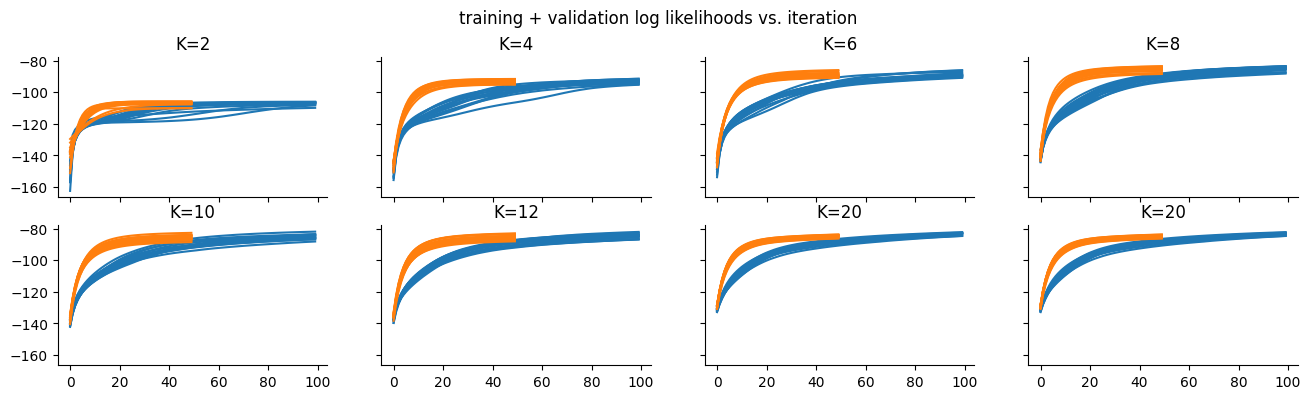

In [138]:
n_conditions = len(all_train_lls)

ncols = 4
nrows = n_conditions // ncols + (n_conditions % ncols > 1)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    figsize=(4*ncols, 2*nrows)
)

for i, ax in enumerate(axs.ravel()):
    n_topics = n_topics_sweep[i]
    ax.plot(all_train_lls[i].T, color='C0')
    ax.plot(all_vldtn_lls[i].T, color='C1')
    ax.set_title(f"K={n_topics}")

fig.suptitle('training + validation log likelihoods vs. iteration', y=1.0)
sns.despine()

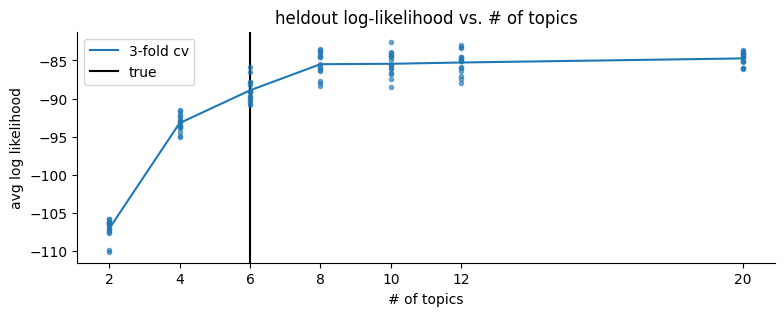

In [136]:
final_vldtn_lls = all_vldtn_lls[...,-1]

plt.figure(figsize=(9,3))
ax = plt.gca()

ax.plot(n_topics_sweep, final_vldtn_lls.mean(axis=-1),
        color='C0', label=f'{n_folds}-fold cv')
for i, n_topics in enumerate(n_topics_sweep):
    ax.scatter(
        jnp.ones(len(lls))*n_topics, final_vldtn_lls[i],
        color='C0', alpha=0.6, marker='.'
    )

true_n_topics = len(true_params.topics)
ax.axvline(true_n_topics, color='k', zorder=0, label='true')

xticks = onp.unique(
    onp.concatenate([n_topics_sweep, [true_n_topics]])
)
ax.set_xticks(xticks)
# ax.xaxis.set_major_locator(auto_integer_tick_locator)

ax.set_xlabel('# of topics')
ax.set_ylabel('avg log likelihood')

ax.legend()

ax.set_title('heldout log-likelihood vs. # of topics')
sns.despine()

The cross-validation results suggest that that the optimal number of topics is $\tilde{K}=8$.

### Examine parameters of fitted model

In [26]:
# ~1 min on swl1 partition, after algorithms have been compiled and without saving
# ~3 min on dev partition, without compilation and with saving
max_stepsize = 1
max_em_steps = 200
prior_params = PriorParams()

n_topics = 8  # found via cross-validation
n_inits = 5
init_key = jr.key(1748)

batched_init_params = vmap(
    initialize_params, in_axes=(0,None,None)
)(jr.split(init_key, n_inits), data, n_topics)

# leading shapes (n_inits, max_em-steps, ...)
all_lls, all_topics, all_weights, all_scales, all_scounts = vmap(
    lambda topics, weights, scales, scounts: em(
        topics, weights, scales, scounts, data, 
        prior_params=prior_params, max_em_steps=max_em_steps, max_stepsize=max_stepsize,
    )
)(*batched_init_params)

# # Save parameters
# with open(f"2024-10-07-K={n_topics}.pkl", "wb") as f:
#     pickle.dump(
#         dict(
#             true_params=true_params,
#             batched_init_params=batched_init_params,
#             all_topics=all_topics,
#             all_weights=all_weights,
#             all_scales=all_scales,
#             all_scounts=all_scounts,
#             all_lls=all_lls,
#             init_key=init_key,
#             prior_params=prior_params,
#             max_stepsize=max_stepsize,
#         ),
#         f,
#     )

In [ ]:
# Load saved parameters
with open(f"2024-10-07-K=8.pkl", "rb") as f:
    tmp = pickle.load(f)

    true_params = tmp['true_params']
    batched_init_params = tmp['batched_init_params']
    all_topics = tmp['all_topics']
    all_weights = tmp['all_weights']
    all_scales = tmp['all_scales']
    all_scounts = tmp['all_scounts']
    all_lls = tmp['all_lls']
    # init_key = tmp['init_key']
    # prior_params = tmp['prior_params']
    # max_stepsize = tmp['max_stepsize']

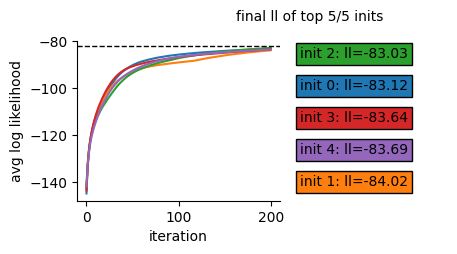

In [109]:
top_n_inits = 5

n_inits, n_steps = all_lls.shape

fmt = ".2f"
# -----------------------------
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(top=0.9, bottom=0.1, right=0.8)  # Leave space on the right hand side

ax = plt.gca()
ax.plot(all_lls.T)
ax.set_xlabel('iteration')
ax.set_ylabel('avg log likelihood')

# Annotate top runs with final ll

sorted_idxs = jnp.argsort(all_lls[:,-1])[:top_n_inits]
ypos = onp.linspace(0.2, 1, endpoint=False, num=top_n_inits)
ypos += (ypos[1] - ypos[0])

for i_init, y in zip(sorted_idxs, ypos):
    c = f"C{i_init}"

    ax.annotate(
        f"init {i_init}: ll={all_lls[i_init,-1]:{fmt}}",
        xy=(1.0, y), xycoords='figure fraction',
        arrowprops={'arrowstyle' : '-', 'ec': c, 'lw': 1},
        bbox={'boxstyle': "Square, pad=0.3", 'fc': c},
        ha='left', va='center',
        backgroundcolor=c,
    )

ax.text(0.9, 1, f"final ll of top {top_n_inits}/{n_inits} inits", transform=fig.transFigure, ha='center')
sns.despine()

# reference model
ref_ll = multinomial_ll(data, *true_params).mean()
ax.axhline(ref_ll, lw=1, ls='--', color='k')

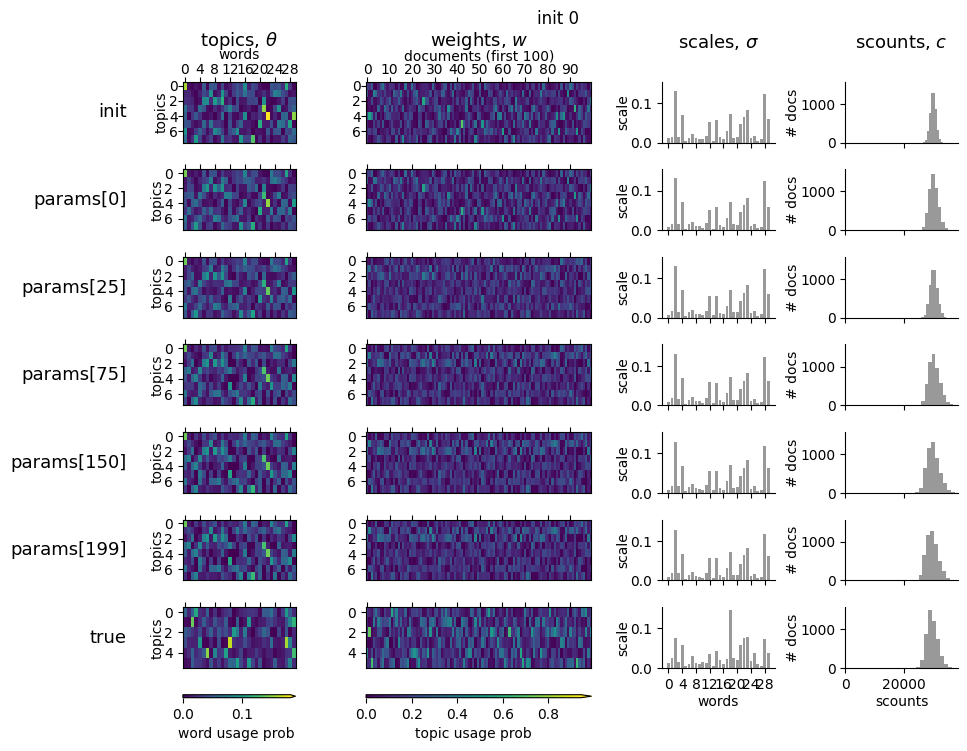

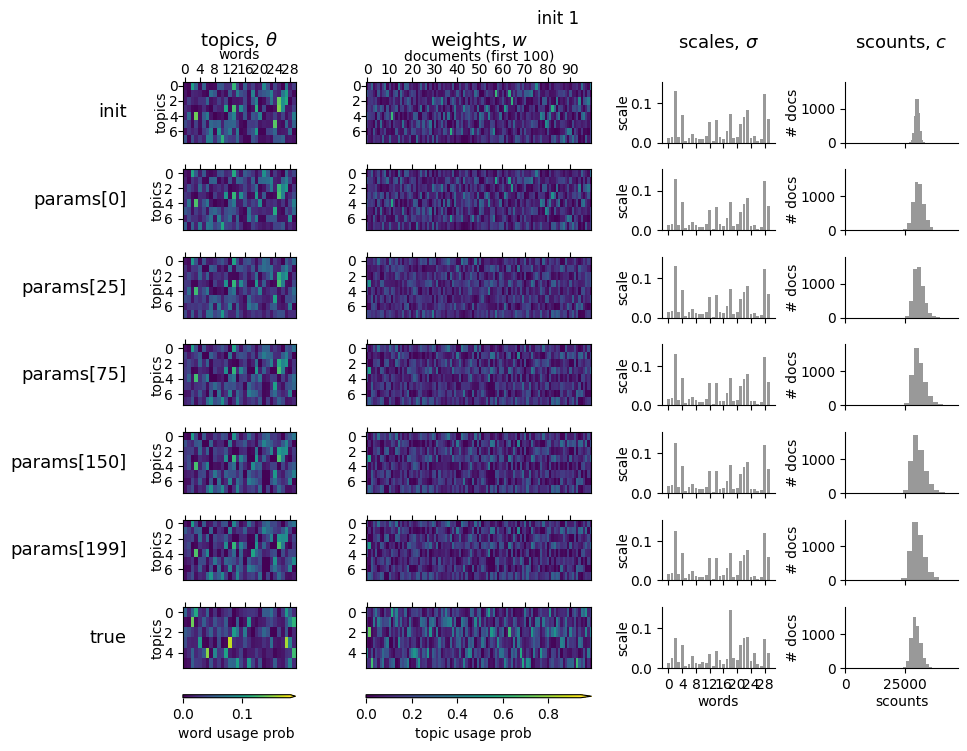

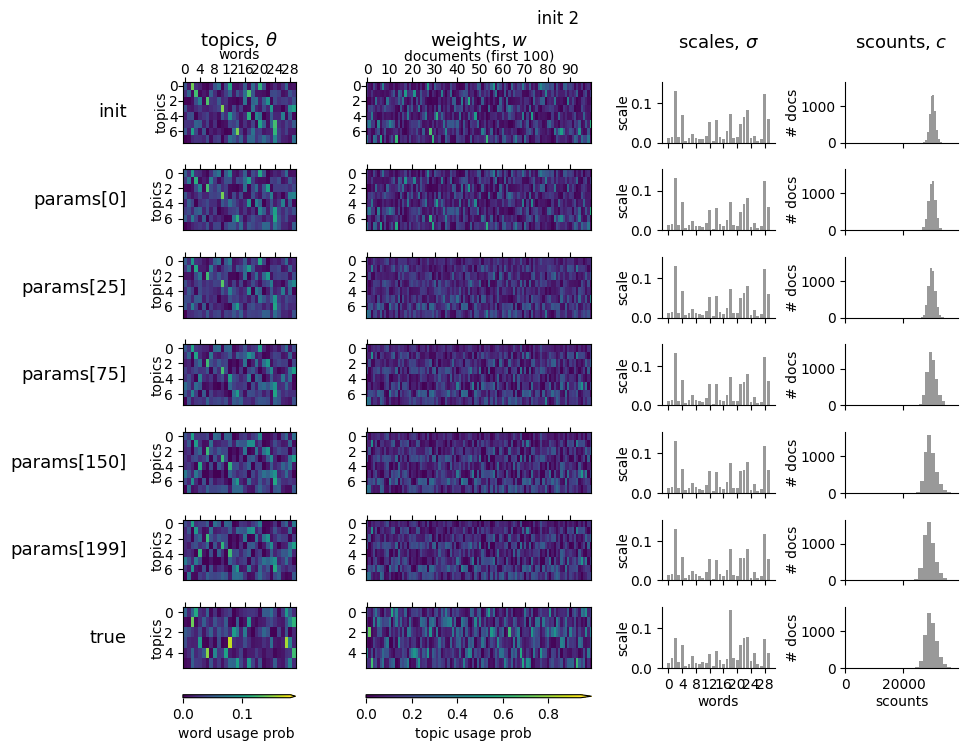

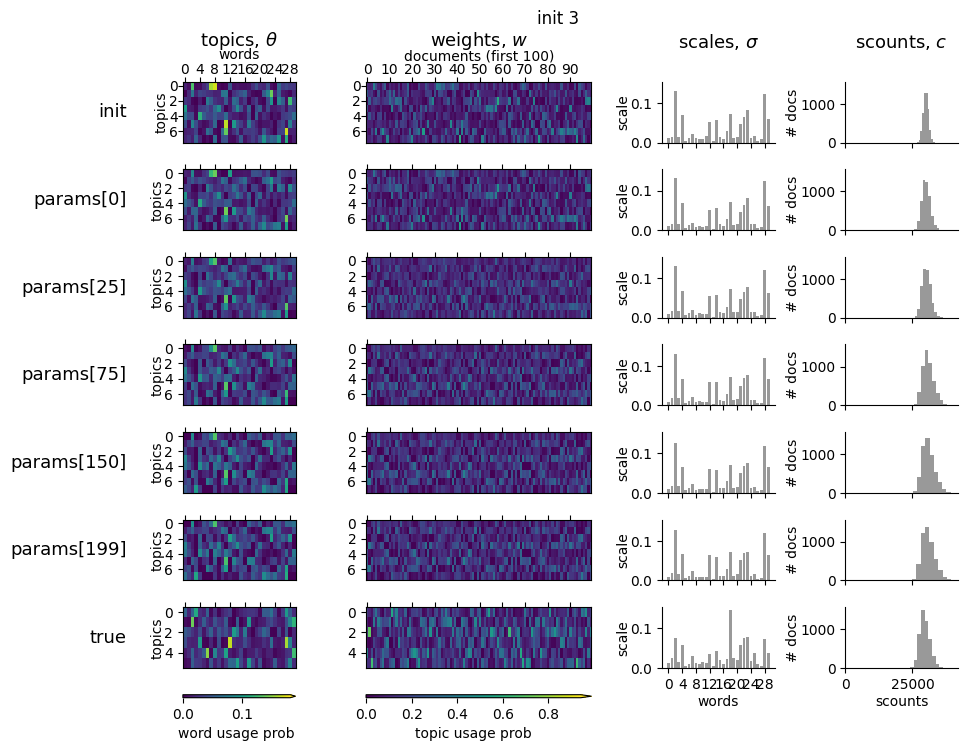

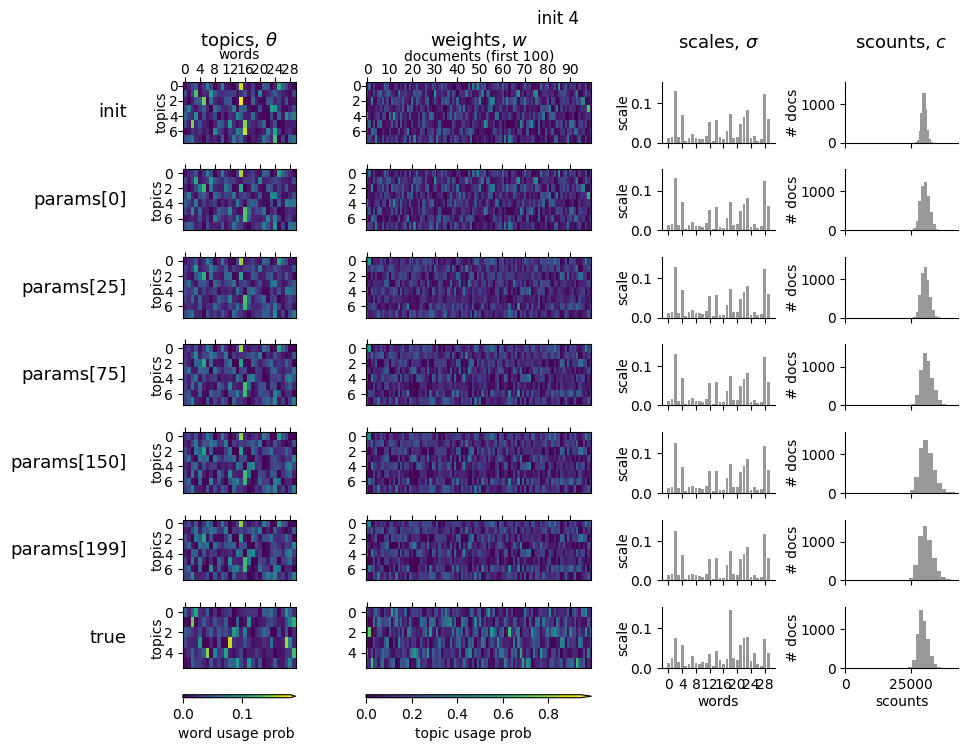

In [92]:
steps = onp.array([0, 25, 75, 150, 199])

n_inits, n_steps = all_topics.shape[:2]


topic_vmax = 1.1 * true_params.topics.max()
weight_vmax = 1.1 * true_params.weights.max()

for i_init in range(n_inits):
    init_params = Params(*[params[i_init] for params in batched_init_params])
    params_by_iter = {
        f"params[{i_step}]": Params(
            all_topics[i_init, i_step],
            all_weights[i_init, i_step],
            all_scales[i_init, i_step],
            all_scounts[i_init, i_step],
        ) for i_step in steps
    }

    tmp = {"init": init_params, **params_by_iter, "true": true_params,}
    fig = compare_params(tmp, topic_vmax=topic_vmax, weight_vmax=weight_vmax)
    
    fig.suptitle(f"init {i_init}", y=0.97)


First, assume that we are **given** the true topics. Are the true topics are a subset of the fitted params.

In [86]:
n_inits = len(all_topics)
all_final_params = [
    Params(
        all_topics[i_init, -1],
        all_weights[i_init, -1],
        all_scales[i_init, -1],
        all_scounts[i_init, -1],
    ) for i_init in range(n_inits)
]

In [102]:
nxent = lambda p, q: (-p * onp.log(q)).sum()

perms, permd_params, perm_costs = [], [], []
for (topics, weights, scales, scounts) in all_final_params:
    
    # cost_matrix: shape (n_true_topics, n_fitted_topics)
    cost_matrix = cdist(true_params.topics, topics, 'cosine') 
    _, i_perm = linear_sum_assignment(cost_matrix)

    permd_topics = topics[i_perm,]
    permd_weights = weights[:,i_perm]
    permd_weights /= permd_weights.sum(axis=-1, keepdims=True)
    
    perms.append(i_perm)
    permd_params.append(Params(permd_topics, permd_weights, scales, scounts))
    perm_costs.append(onp.diag(cost_matrix[:, i_perm]).sum())

Text(0.5, 1.0, 'min cosine dist perm, given true topics')

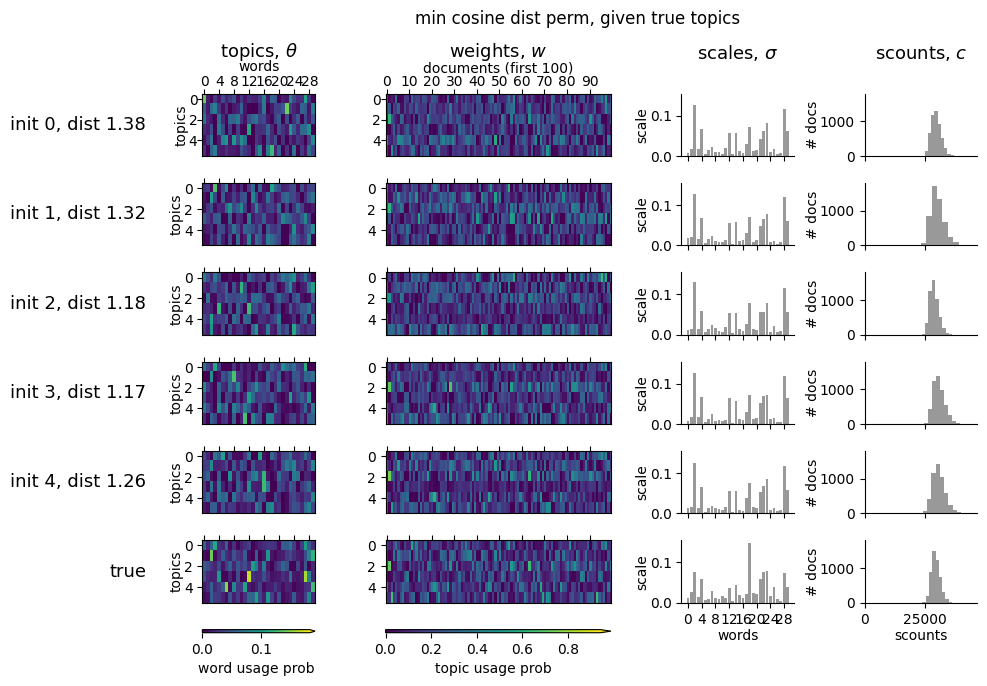

In [112]:
n_inits = len(all_topics)

topic_vmax = 1.1 * true_params.topics.max()
weight_vmax = 1.1 * true_params.weights.max()

tmp = {
    **{f'init {i_init}, dist {perm_costs[i_init]:.2f}': permd_params[i_init]
        for i_init in range(n_inits)
    },
    'true': true_params
}
fig = compare_params(tmp, topic_vmax=topic_vmax, weight_vmax=weight_vmax)

fig.suptitle(f'min cosine dist perm, given true topics', y=1.0)